In [8]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
import time_of_emrgence_calc as toe

In [10]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:43165
-   dashboard at:        /proxy/38943/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:38437'
-         Start Nanny at: 'tcp://127.0.0.1:39323'
-         Start Nanny at: 'tcp://127.0.0.1:45147'
-         Start Nanny at: 'tcp://127.0.0.1:37357'
-         Start Nanny at: 'tcp://127.0.0.1:39645'
-         Start Nanny at: 'tcp://127.0.0.1:36231'
-         Start Nanny at: 'tcp://127.0.0.1:35853'
- Register worker <WorkerState 'tcp://127.0.0.1:36649', name: 2, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:36649
- Starting established connection to tcp://127.0.0.1:51790
- Register worker <WorkerState 'tcp://127.0.0.1:33587', name: 6, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:33587
- Starting established connection to tcp://127.0.0.1:51766
- Register worker <WorkerState 'tcp://127.0.0.1:42839', name: 0, status

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38943/status,
Dashboard: /proxy/38943/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43165,Workers: 7
Dashboard: /proxy/38943/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:42839,Total threads: 4
Dashboard: /proxy/37283/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38437,


In [11]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [12]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [13]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

0.3.0


In [55]:
# Only 43MB - load into memory
best_ds = best_ds.compute()

In [56]:
best_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 2.237 2.238 2.24 2.241 2.242 2.243 2.244
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

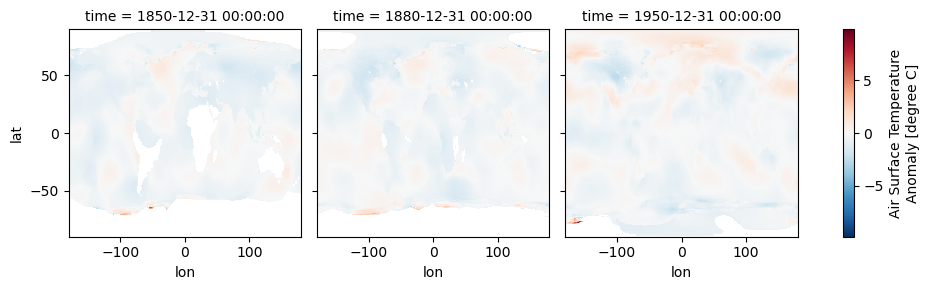

In [57]:
best_ds.isel(time=[0, 30, 100]).plot(col='time')

In [18]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
nan nan nan nan nan nan ... -0.027 -0.02725 -0.02678 -0.02644 -0.02708 -0.02708
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

# Calculations

In [20]:
window = 20

## Signal-to-Noise

### Trend Fit

In [58]:
best_ds_no_base = best_ds.sel(time=best_ds.time.dt.year>1900)
best_ds_no_base

<xarray.DataArray 'temperature' (time: 124, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 2.237 2.238 2.24 2.241 2.242 2.243 2.244
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [177]:
%%time
# As these are anomalies, the signal is just going to be the
ds_best_poly = stats.trend_fit(best_ds_no_base, method='POLYNOMIAL', order=4)#'LOWESS', lowess_window=40)

CPU times: user 14.7 s, sys: 2.38 s, total: 17.1 s
Wall time: 14.4 s


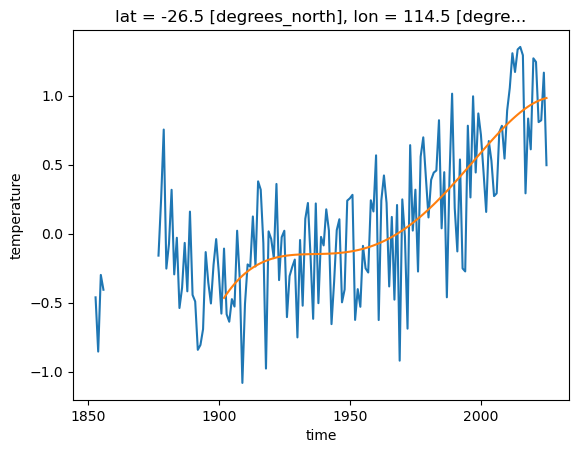

In [182]:
# Point from western Austrlia, where there are odd things in the data
lat = -26.994458 ;lon = 114.934331

best_ds.sel(lat=lat, lon=lon, method='nearest').plot()
ds_best_poly.sel(lat=lat, lon=lon, method='nearest').plot()

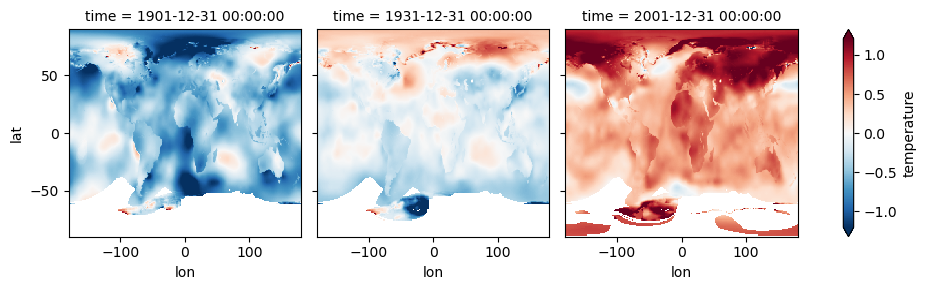

In [183]:
ds_best_poly.isel(time=[0, 30, 100]).plot(col='time', robust=True)

In [184]:
noise_ds = base_period_ds.std(dim='time')

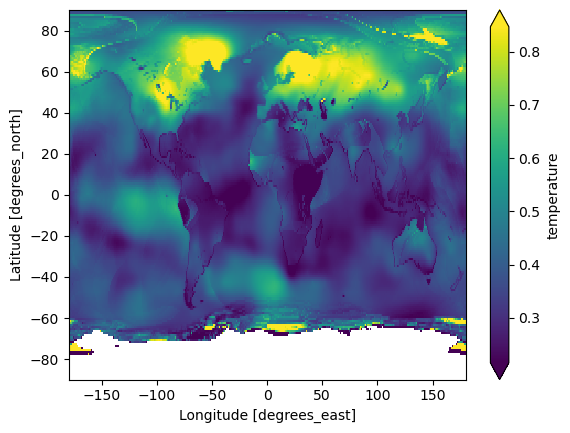

In [185]:
noise_ds.plot(robust=True)

In [234]:
base_period_ds_average = base_period_ds.mean(dim='time').fillna(0)
base_period_ds_average

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... -0.2539 -0.2488 -0.2487 -0.2487 -0.2499 -0.2503
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [236]:
ds_best_poly_signal = ds_best_poly - base_period_ds_average

In [237]:
ds_best_sn_poly = ds_best_poly_signal/noise_ds

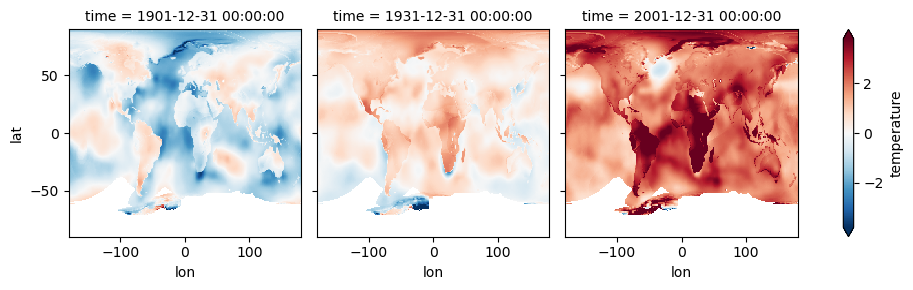

In [238]:
ds_best_sn_poly.isel(time=[0, 30, 100]).plot(col='time', robust=True)

## KS-test

In [21]:
%%time
local_ks_ds = toe.apply_kstest_along_array(best_ds, window)

CPU times: user 22min 6s, sys: 2min 20s, total: 24min 27s
Wall time: 21min 59s


In [22]:
local_ks_ds_2 = toe.kstest_with_ufunc(best_ds, window, base_period_ds)

# Getting ToE

In [239]:
sn_does_not_emerge = (ds_best_sn_poly.isel(time=-1) < 2)

In [224]:
toe_does_not_emerge = (local_ks_ds_2.isel(time=-1) > 0.05)

In [240]:
# Define the colors you want
colors = [(1, 1, 1), (0.5, 0.5, 0.5)]  # White to Gray
cmap_name = 'grey_white_cmap'
# Create a LinearSegmentedColormap
grey_white_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

In [241]:
not_stable_kwargs = dict(cmap= grey_white_cmap, add_colorbar=False)

Text(0.5, 1.0, 'KS')

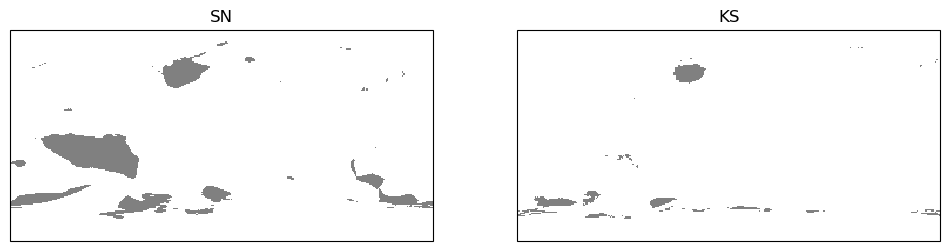

In [242]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(1,2,i, projection=ccrs.PlateCarree()) for i in range(1,3)]

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs)
toe_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs)
axes[0].set_title('SN')
axes[1].set_title('KS')

In [243]:
sn_toe_ds = toe.get_permanent_exceedance(ds_best_sn_poly, threshold=2, comparison_func=np.greater)

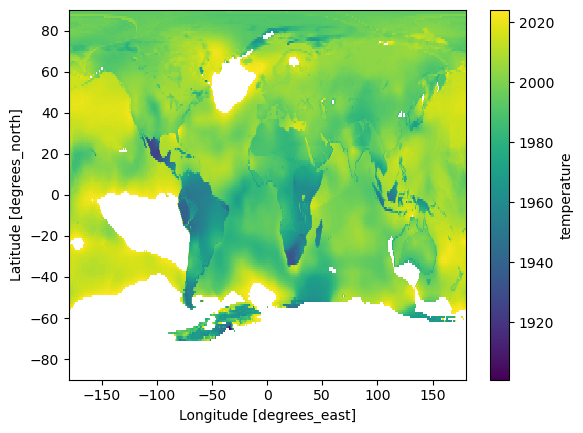

In [244]:
sn_toe_ds.plot()

In [190]:
local_ks_subset_ds = local_ks_ds.sel(time=local_ks_ds.time.dt.year>1900)

In [191]:
ks_toe_ds = toe.get_permanent_exceedance(local_ks_subset_ds, threshold=0.01, comparison_func=np.less)

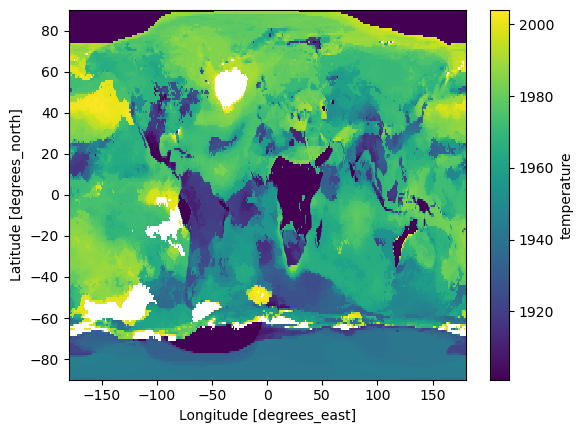

In [192]:
ks_toe_ds.plot()

## Comparison

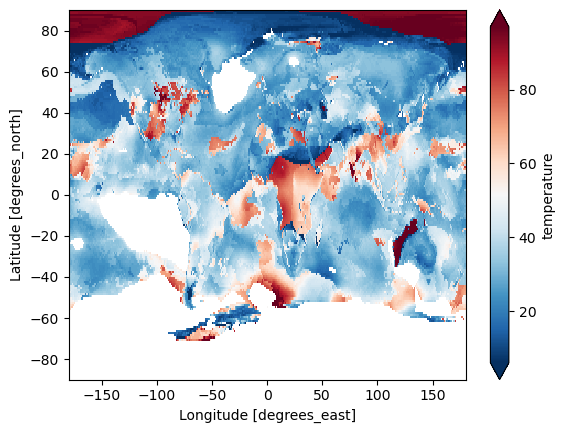

In [245]:
(sn_toe_ds - ks_toe_ds).plot(robust=True, cmap='RdBu_r')

Text(0.5, 1.0, 'Difference (SN - KS)')

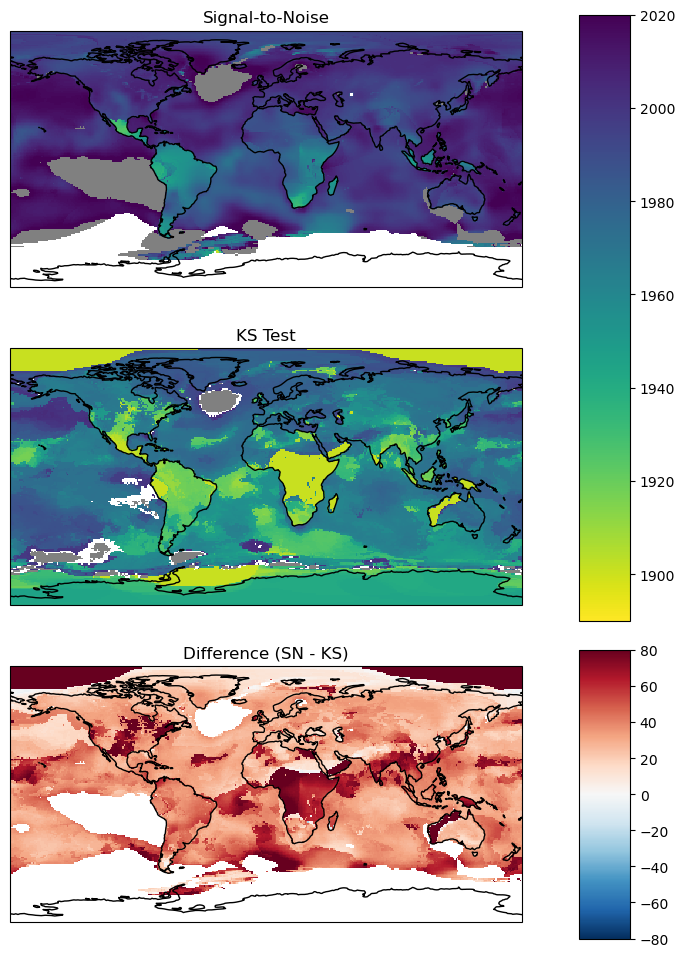

In [251]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs)
toe_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs)


sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

Text(0.5, 1.0, 'Difference (SN - KS)')

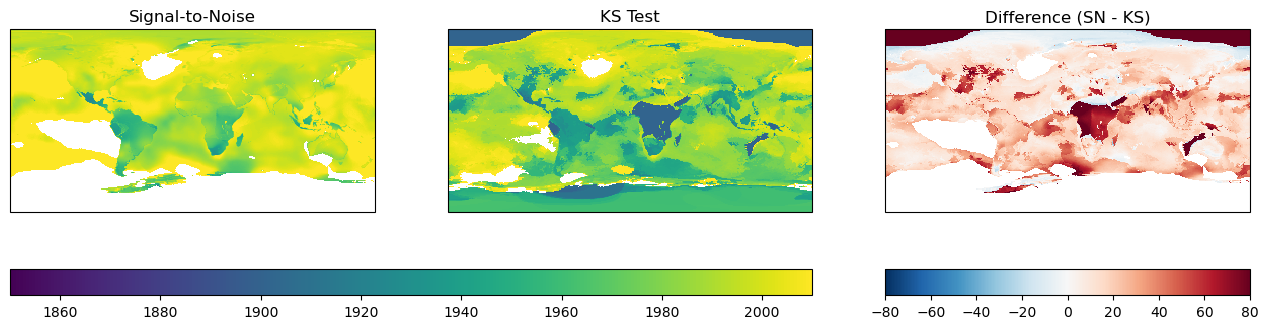

In [67]:
fig = plt.figure(figsize=(16, 4))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[0, i], projection=projection) for i in range(3)]

sn_toe_ds.plot(ax=axes[0], add_colorbar=False, vmin=1850, vmax=2010)
toe_plot = ks_toe_ds.plot(ax=axes[1], add_colorbar=False, vmin=1850, vmax=2010)

cbar_axes1 = plt.subplot(gs[1, :2])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[1, 2])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='horizontal')


axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [252]:
lat=3.263204
lon=12.78272

In [257]:
selection_kwargs = dict(lat=lat, lon=lon, method='nearest')

In [ ]:
ks_toe_ds

In [262]:
ks_toe_ds.sel(**selection_kwargs).values

array(1901.)

In [261]:
sn_toe_ds.sel(**selection_kwargs).values

array(1978.)

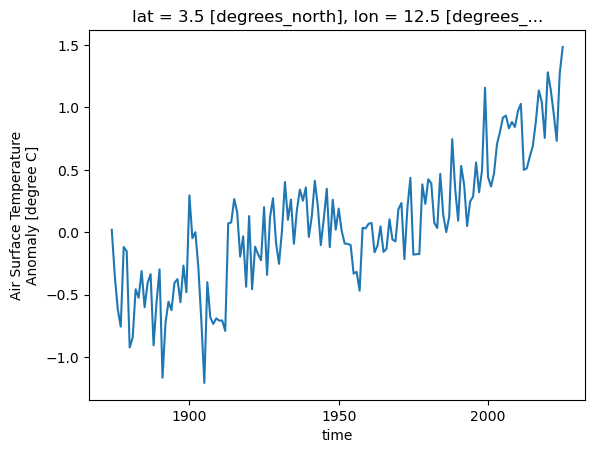

In [259]:
best_ds.sel(**selection_kwargs).plot()